In [1]:
from qutip import *

import numpy as np
from numpy import pi as pi
from numpy import sqrt as sqrt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)

from scipy.optimize import curve_fit as cf

In [2]:
g1 = basis(6,0)
g2 = basis(6,1)
m1 = basis(6,2)
m2 = basis(6,3)
e1 = basis(6,4)
e2 = basis(6,5)

In [3]:
def boltzmann(gs, T):
    return np.exp(-6.26e-34*gs*1e9/(1.38e-23*T))

def sigmoid(t, risetime, t0):
    a = risetime/(2*4.4)
    return 1/(np.exp(-(t-t0)/a)+1)

def pulse_sig(t, t0, width, risetime=1):
    return np.where(t<width/2+t0, sigmoid(t,risetime,t0),1-sigmoid(t,risetime,t0+width)).astype(float)

def pulse_rect(t, t0, width):
    return np.where( (t0<t) & (t<(width+t0)), 1.0, 0.0).astype(float)

def seqC3(t, args): 
    tstart = args['tstart']
    pulsewidth = args['pulsewidth']
    return np.where(t<pulsewidth/2+tstart, sigmoid(t,0.86,4+tstart),1-sigmoid(t,0.86,pulsewidth+2+tstart))

In [4]:
c = 299792458
hbar = 6.62e-34/(2*np.pi)
omega0 = c/737e-9 * 2*pi

Gamma = 0.12
eta = 5
psat = 50

p = 0.15*10e3
mod1 = 1
mod2 = 1

p1 = mod1 * p
psat1 = psat
Gamma1 = Gamma
s1 = p1/psat1
Omega1 = sqrt(s1/2) * Gamma1

p2 = mod2 * p
psat2 = psat1 * eta
Gamma2 = Gamma1/eta
s2 = p/psat2
Omega2 = sqrt(s2/2) * Gamma2

Delta = 2*s1*np.sqrt(Gamma1)
Delta = 0.5
Omega = Omega1 * Omega2 / (2*Delta) # sqrt(s1/2) * Gamma1 * sqrt(s2/2) * Gamma2 /(4 * Delta)
Gamma_os = Omega1**2*Gamma/(4*Delta)
print(Delta*1e3, Omega*1e3, Gamma_os*1e3)

print("Tin Quantum Control Parameters")
s = 650/4.6
Gamma = 0.035
Delta = 1.2
eta = 80
print("Sat. Parameter: ", s1, "Linewidth: ", Gamma*sqrt(1+s))
print("Rabi Freq.: ", s*Gamma**2/(sqrt(eta)*4*Delta), "Optical scatt. rate: ", 2*pi*s*Gamma**3/(8*Delta**2))

500.0 19.319627325598184 12.959999999999997
Tin Quantum Control Parameters
Sat. Parameter:  30.0 Linewidth:  0.41751985112920864
Rabi Freq.:  0.004031859436331993 Optical scatt. rate:  0.0033043576488802303


In [5]:
gs = 100
T = 5
eta_spin = 5
eta_cd = 2

T1_opt = 1.7
T1_orb = 10
T1_spin = 1000

Gamma1_opt = 1/(2*pi*T1_opt)
Gamma1_spin = 1/(2*pi*T1_spin)
Gamma1_orb = 1/(1+boltzmann(gs,T))*1/(2*pi*T1_orb)
Gamma1_orb_em = Gamma1_orb
Gamma1_orb_abs = boltzmann(gs, T) * Gamma1_orb_em
c_ops = [
sqrt(Gamma1_opt)*(g1 + 1/eta_spin*g2 + 1/eta_cd*(1/eta_spin*m1 + m2))*e2.dag(),
sqrt(Gamma1_opt)*(g1 + 1/eta_spin*g2 + 1/eta_cd*(m1 + 1/eta_spin*m2))*e1.dag(),
(sqrt(Gamma1_orb_em) * g1 + sqrt(Gamma1_spin)*m2)*m1.dag(),
(sqrt(Gamma1_orb_em) * g2 + sqrt(Gamma1_spin)*m1)*m2.dag(),
(sqrt(Gamma1_orb_abs) * m1 + sqrt(Gamma1_spin)*g2)*g1.dag(),
(sqrt(Gamma1_orb_abs) * m2 + sqrt(Gamma1_spin)*g1)*g2.dag()
]
rho0 = steadystate(Qobj(np.zeros((6,6))), c_ops)
rho0

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0.35621818 0.         0.         0.06125142 0.         0.        ]
 [0.         0.35621818 0.06125142 0.         0.         0.        ]
 [0.         0.06125142 0.14378182 0.         0.         0.        ]
 [0.06125142 0.         0.         0.14378182 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]

3690 3690


C:\Users\Marco\AppData\Local\Temp\ipykernel_17800\3387435258.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(-(t-t0)/a)+1)


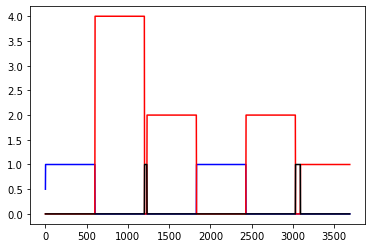

In [17]:
dt = 1
T = 600
tau_stp = 30
tau_str = tau_stp
tau_stop = 90
taus = np.arange(tau_str, tau_stop, tau_stp)

L = len(taus)* 3*T + np.sum(taus)
t = np.arange(0, L, dt)
print(L, len(t))
t0 = 0
risetime = 1
reset_seq = np.zeros_like(t)
raman_seq = np.zeros_like(t)
init_seq = np.zeros_like(t)

for tau in taus:
    reset_seq += pulse_sig(t, t0, T, risetime)
    t0 += T
    init_seq += pulse_sig(t, t0, T, risetime)
    t0 += T
    raman_seq += pulse_sig(t, t0, tau, risetime)
    t0 += tau
    init_seq += pulse_sig(t, t0, T, risetime)
    t0 += T

plt.plot(t, reset_seq, '-b')
plt.plot(t, init_seq, '-r')
plt.plot(t, raman_seq, '-k')

Rabi Period.:  161.6244071283537 Optical scatt. rate:  0.10937500000000004


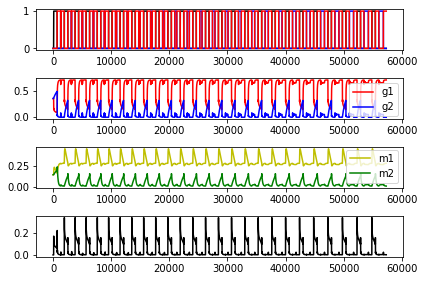

In [8]:
psat = 50
mod = 0.2
p = mod*10e3
eta = 2
s = p/psat
Omega1 = 2*Gamma1_opt
Omega2 = 10*Gamma1_opt
Delta = 1.4
delta = 0*2*pi*0.005
print("Rabi Period.: ", 1/(s*Gamma**2/(sqrt(eta)*4*Delta)), "Optical scatt. rate: ", s*Gamma**3/(8*Delta**2)*1e3)

Hraman = delta*g2*g2.dag() + Delta * e1*e1.dag() + Omega1/2 * (g1*e1.dag() + e1*g1.dag()) + Omega2/2 * (g2*e1.dag() + e1*g2.dag())
Hreset = Omega1/2 * (g1*e1.dag() + e1*g1.dag())
Hinit = Omega1/2 * (g2*e2.dag() + e2*g2.dag())

e_ops = [g1*g1.dag(), g2*g2.dag(), m1*m1.dag(), m2*m2.dag(), e1*e1.dag(), e2*e2.dag()]
exps = mesolve([[Hreset, reset_seq], [Hinit, init_seq], [Hraman, raman_seq]], rho0, t, e_ops=e_ops, c_ops=c_ops).expect

fig, axs = plt.subplots(4,1)
axs[0].plot(t, reset_seq, '-k')
axs[0].plot(t, raman_seq, '-b')
axs[0].plot(t, init_seq, '-r')
axs[1].plot(t, exps[0], '-r', label='g1')
axs[1].plot(t, exps[1], '-b', label='g2')
axs[1].legend()
axs[2].plot(t, exps[2], '-y', label='m1')
axs[2].plot(t, exps[3], '-g', label='m2')
axs[2].legend()
axs[3].plot(t, (exps[4] + exps[5]), '-k')
plt.tight_layout()

C:\Users\Marco\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


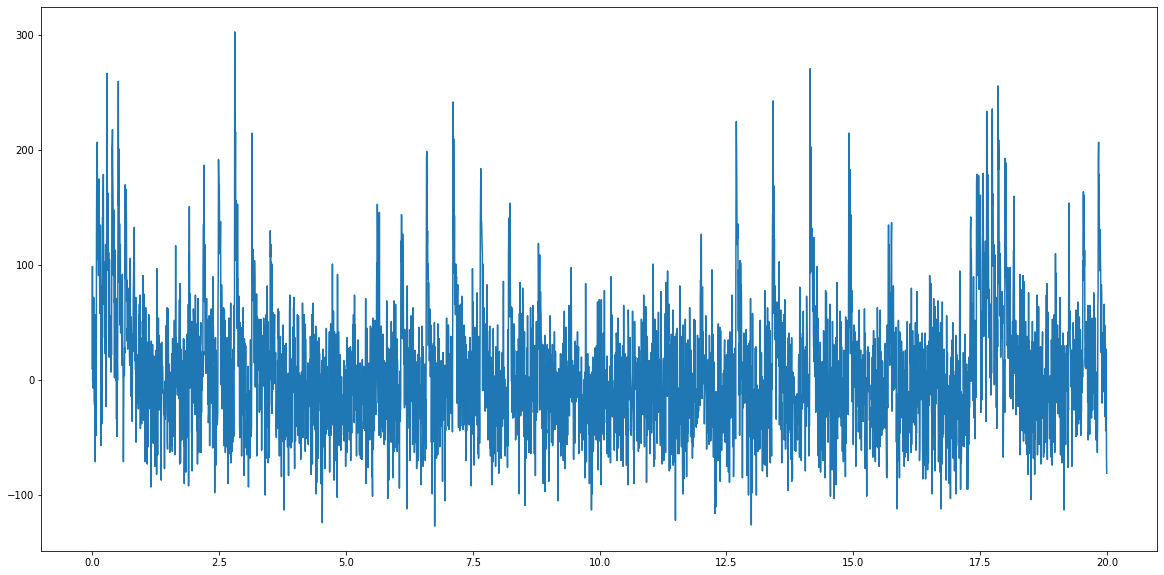

In [58]:
data = np.genfromtxt(r"C:\Users\Marco\Desktop\Github\Quantum-Dynamics\Data\PulsedRaman\PulsedMeasurement\Histogram_2022-12-02_22-53-19.txt")
ts = data[1:,0]*1e-6
cts = data[1:,1]

hist, bins = np.histogram(cts, bins=200)
bins_ctr = (bins[1:] + bins[:-1])/2

gaussian = lambda x, mu, sigma, A, c: A/sqrt(2*pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2)) + c
popt, pcov = cf(gaussian, bins_ctr, hist, p0 = (np.median(bins), np.median(bins), np.amax(hist), np.amin(hist)))

cts -= np.median(cts)
plt.plot(ts, cts)
plt.show()

In [59]:
Gamma_1s = 1/(2*np.pi*2000)
Gamma_1o = 1/(boltzmann(50, 5) + 1)*1/(2*np.pi*40)
delta = 0

Hinit = Omega1/2 * (g1*e1.dag() + e1*g1.dag())
Hreset = Omega1/2 * (g2*e2.dag() + e2*g2.dag())
HRaman = delta*g2*g2.dag() + Delta*e1*e1.dag() + Omega1/2 * (g1*e1.dag() + e1*g1.dag()) + Omega2/2 * (g2*e1.dag() + e1*g2.dag())
c_ops = [
        np.sqrt(Gamma_1o)*g1*m1.dag(),
        np.sqrt(Gamma_1o)*g2*m2.dag(),
        boltzmann(50, 5)*np.sqrt(Gamma_1o)*m1*g1.dag(),
        boltzmann(50, 5)*np.sqrt(Gamma_1o)*m2*g2.dag(),
        np.sqrt(Gamma1)*g1*e1.dag(),
        np.sqrt(Gamma2)*g2*e1.dag(),
        np.sqrt(Gamma1)*g2*e2.dag(),
        np.sqrt(Gamma2)*g1*e2.dag(),
        np.sqrt(Gamma_1s)*g1*g2.dag(),
        np.sqrt(Gamma_1s)*g2*g1.dag(),
        np.sqrt(Gamma_1s)*e1*e2.dag(),
        np.sqrt(Gamma_1s)*e2*e1.dag(),
        ]
e_ops = [
    g1*g1.dag(),
    g2*g2.dag(),
    e1*e1.dag(),
    e2*e2.dag()
]

rho0 = 0.5*g1*g1.dag() + 0.5*g2*g2.dag()
[[Hreset, pulse_reset],
 [Hinit, pulse_init1],
 [HRaman, pulse_raman],
 [Hinit, pulse_init2]
]
result = mesolve([
                    [Hreset, pulse_reset],
                    [Hinit, pulse_init1],
                    [HRaman, pulse_raman],
                    [Hinit, pulse_init2]
                ],                 
                 rho0, t, e_ops=e_ops, c_ops=c_ops)
exps = result.expect

NameError: name 'pulse_reset' is not defined

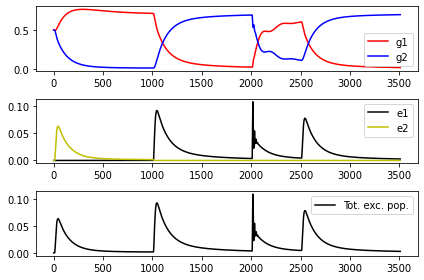

In [48]:
labels = ['g1', 'g2', 'e1', 'e2']
colors = ['r', 'b', 'k', 'y']
fig, axs = plt.subplots(3, 1)
                        
for i, exp in enumerate(exps):
    axs[i // 2].plot(t, exp, label = labels[i], color=colors[i])    
    
axs[2].plot(t, exps[2] + exps[3], '-k', label='Tot. exc. pop.')
for ax in axs:
    ax.legend()
    
plt.tight_layout()

-0.00010610028826212725 4.054199245203729


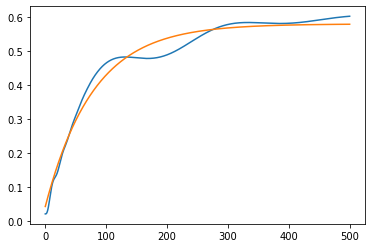

In [49]:
mask = np.argwhere(pulse_raman==1).flatten()
ts = t[mask]-t[mask][0]
cts = exps[0][mask]
plt.plot(ts, cts)
rabi = lambda t, A, Omega, Gamma, c: A*(1-np.cos(Omega*t)*np.exp(-Gamma*t) + c)
p0 = (np.amax(cts), Omega, 0.5*Gamma_os, np.mean(cts))
popt, pcov = cf(rabi, ts, cts, p0=p0)
plt.plot(ts, rabi(ts, *popt))
print(popt[1]*1e3, popt[2]*1e3 / (pi))

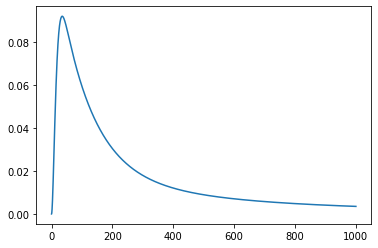

In [50]:
mask = np.argwhere(pulse_init1==1).flatten()
ts = t[mask]-t[mask][0]
cts = (exps[2]+exp[3])[mask]
plt.plot(ts, cts)

In [216]:
Gamma1 = 1/2
Gamma2 = Gamma1

Gamma_spin = 1/(2*np.pi*200)
Gamma_spin_deph = 1/(2*np.pi*10000)
Gamma_orb = 1/(2*np.pi*40)

gs = 50
T = 4

c:\program files (x86)\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


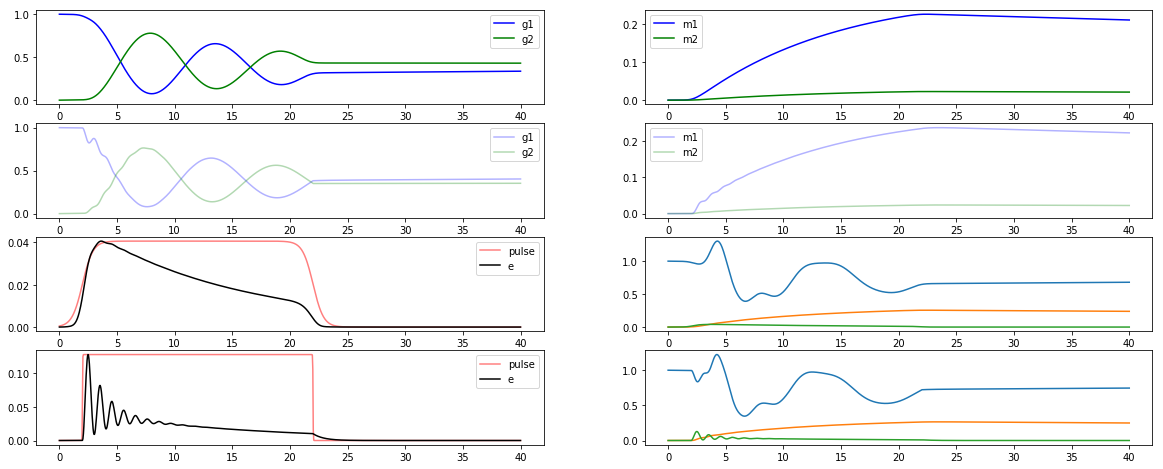

In [217]:
pulsewidth = 20
risetime = 5
tlist = np.linspace(0, 2*pulsewidth, 1000)

delta = 5
Delta = 0
eta = 0.1
sat = 5
H = Delta*g2*g2.dag() + delta*e*e.dag()

Omega1 = sat*Gamma1
Omega2 = sat*Gamma2

Hint1 = Omega1/2 * (g1*e.dag() + e*g1.dag())
Hint2 = Omega2/2 * (g2*e.dag() + e*g2.dag())

c_ops = [
    np.sqrt(Gamma1)*g1*e.dag(),
    np.sqrt(eta*Gamma1)*g2*e.dag(),
    np.sqrt(Gamma2)*m1*e.dag(),
    np.sqrt(eta*Gamma2)*m2*e.dag(),
    np.sqrt(Gamma_spin)*g1*g2.dag(),
    np.sqrt(Gamma_spin*boltzmann(5,T))*g2*g1.dag(),
    np.sqrt(Gamma_orb)*(g1 + eta*g2)*m1.dag(),
    np.sqrt(Gamma_orb*boltzmann(5,T))*(eta*g1 + g2)*m2.dag(),
    np.sqrt(Gamma_spin_deph)*(g2*g2.dag() - g1*g1.dag())
]
e_ops = [
    g1*g1.dag(),
    g2*g2.dag(),
    m1*m1.dag(),
    m2*m2.dag(),
    e*e.dag()
]
rho0 = g1*g1.dag()

risetime_sig = 4
risetime_step = 0.1

result_sig = mesolve([H, [Hint1 + Hint2, pulse(tlist, risetime_sig, pulsewidth, risetime_sig/2)]], rho0, tlist, e_ops=e_ops, c_ops=c_ops)
result_step = mesolve([H, [Hint1 + Hint2, pulse(tlist, risetime_step, pulsewidth, risetime_sig/2)]], rho0, tlist, e_ops=e_ops, c_ops=c_ops)

fig, axs = plt.subplots(4,2)

axs[0,0].plot(tlist, result_sig.expect[0], label='g1', color='b')
axs[0,0].plot(tlist, result_sig.expect[1], label='g2', color='g')
axs[0,0].legend()
axs[1,0].plot(tlist, result_step.expect[0], label='g1', color='b', alpha=0.3)
axs[1,0].plot(tlist, result_step.expect[1], label='g2', color='g', alpha=0.3)
axs[1,0].legend()

axs[0,1].plot(tlist, result_sig.expect[2], label='m1', color='b')
axs[0,1].plot(tlist, result_sig.expect[3], label='m2', color='g')
axs[0,1].legend()
axs[1,1].plot(tlist, result_step.expect[2], label='m1', color='b', alpha=.3)
axs[1,1].plot(tlist, result_step.expect[3], label='m2', color='g', alpha=.3)
axs[1,1].legend()

axs[2,0].plot(tlist, pulse(tlist, risetime_sig, pulsewidth, risetime_sig/2)*np.amax(result_sig.expect[4]), label='pulse', color='r', alpha=0.5)
axs[2,0].plot(tlist, result_sig.expect[4], label='e', color='k')
axs[2,0].legend()
axs[3,0].plot(tlist, pulse(tlist, risetime_step, pulsewidth, risetime_sig/2)*np.amax(result_step.expect[4]), label='pulse', color='r', alpha=0.5)
axs[3,0].plot(tlist, result_step.expect[4], label='e', color='k')
axs[3,0].legend()

axs[2,1].plot(tlist, result_sig.expect[0]+result.expect[1])
axs[2,1].plot(tlist, result_sig.expect[2]+result.expect[3])
axs[2,1].plot(tlist, result_sig.expect[4])
axs[3,1].plot(tlist, result_step.expect[0]+result.expect[1])
axs[3,1].plot(tlist, result_step.expect[2]+result.expect[3])
axs[3,1].plot(tlist, result_step.expect[4])